In [1]:
# Required Packages
import pandas as pd
import numpy as np
import math
import json
from collections import defaultdict

# preprocessing
from sklearn.impute import SimpleImputer

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex

## progress bar
import progressbar

## seaborn
import seaborn as sns
sns.set_context('paper', rc={'font.size':12,'axes.titlesize':14,'axes.labelsize':12})
sns.set_style('white')

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

## missingno
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

<img src='https://upload.wikimedia.org/wikipedia/en/thumb/d/d3/Starbucks_Corporation_Logo_2011.svg/474px-Starbucks_Corporation_Logo_2011.svg.png' width='250' align="center"/>

# Starbucks Offer Personalizations

In this article, we investigate a set simulated dataset that mimics customer behavior on the Starbucks rewards mobile app. Starbucks tends to send out offers to users of the mobile app once every few days. These offers are exclusive, that is not all users receive the same offer. An offer can contain a  discount for their products or sometimes BOGO (buy one get one free). These offers have a validity period before the offer expires. The article here is inspired by a [towardsdatascience.com](https://towardsdatascience.com/using-starbucks-app-user-data-to-predict-effective-offers-20b799f3a6d5) article.

### Table of contents
* [Dataset](#Dataset)
* [Preprocessing](#Preprocessing)
    * [Portfolio Data](#Portfolio-Data)
    * [Profile Data](#Portfolio-Data)
    * [Transcript Data](#Transcript-Data)
* [Problem Description](#Problem-Description)
* [Feature Engineering](#Feature-Engineering)

## Datasets

The data is contained in three files:

In [2]:
def Line(N): return N*'='
def Header(Inp, Length = 120):
    print(Back.BLACK + Fore.CYAN + Style.NORMAL + '%s' % Inp + Style.RESET_ALL
         + Fore.BLUE + Style.NORMAL + ' %s' % Line(Length- len(Inp) - 1) + Style.RESET_ALL)
def Bottom(Length = 120):
    print(Fore.BLUE + Style.NORMAL + '%s' % Line(Length) + Style.RESET_ALL)
    
# Portfolio Dataset
Header('Portfolio Dataset:')
Portfolio = pd.read_json('StarBucks/portfolio.json', orient='records', lines=True)
Portfolio.columns = [x.title().replace('Id','ID') for x in Portfolio.columns]
display(Portfolio.head().style.hide_index())

# Profile Dataset
Header('Profile Dataset:')
Profile = pd.read_json('StarBucks/profile.json', orient='records', lines=True)
Profile.columns = [x.title().replace('Id','ID') for x in Profile.columns]
display(Profile.head().style.hide_index())

# Transcript Dataset
Header('Transcript Dataset:')
Transcript = pd.read_json('StarBucks/transcript.json', orient='records', lines=True)
Transcript.columns = [x.title() for x in Transcript.columns]
display(Transcript.head().style.hide_index())
Bottom()

Portfolio Dataset: =====================================================================================================


Reward,Channels,Difficulty,Duration,Offer_Type,ID
10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


Profile Dataset: =======================================================================================================


Gender,Age,ID,Became_Member_On,Income
None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,nan
F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000
None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,nan
F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000
None,118,a03223e636434f42ac4c3df47e8bac43,20170804,nan


Transcript Dataset: ====================================================================================================


Person,Event,Value,Time
78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


<div class="alert alert-block alert-success">
<font size="+1"><b>Feature Description in the Datasets</b></font>
</div>

<button type="button" class="btn btn-lg btn-primary" disabled>Portfolio Dataset</button>

| Feature | Description |
|----------------------------|------------------------------------------------------|
| Reward (int) | Given reward for completing an offer |
| Channels (list of strings) | Email, mobile app, social media, etc |
| Difficulty (int) | Minimum spending requirement for completing an offer |
| Duration (int) | Time that an offer is valid |
| Offer_Type (string) | Type of offer |
| ID (string)       | Offer ID |

<button type="button" class="btn btn-lg btn-primary" disabled>Profile Dataset</button>

| Feature | Description |
|------------------------|--------------------|
| Gender (str) | Customers gender |
| Age (int) | Customers age |
| ID (str) | Customers ID |
| Became_Member_On (int) | Date of membership |
| Income (float) | Customer's income |

<button type="button" class="btn btn-lg btn-primary" disabled>Transcript Dataset</button>

| Feature | Description |
|---------------------------|--------------------------------------------------|
| Person (str) | Customer ID |
| Event (str) | Record description |
| time (int) | Time in hours (since the beginning of the study) |
| Value - (dict of strings) | Offer ID or transaction amount |

# Preprocessing

In [3]:
def Data_info(Inp, Only_NaN = False):
    Out = Inp.dtypes.to_frame(name='Data Type').sort_values(by=['Data Type'])
    Out = Out.join(Inp.isnull().sum().to_frame(name = 'Number of NaN Values'), how='outer')
    Out ['Size'] = Inp.shape[0]
    Out['Percentage'] = np.round(100*(Out['Number of NaN Values']/Inp.shape[0]),2)
    if Only_NaN:
        Out = Out.loc[Out['Number of NaN Values']>0]
    return Out

## Portfolio Data

The first thing that needs to be done is converting the categorical variables (that are important for our analysis) into dummy variables. We have,

In [4]:
Temp= Portfolio['Channels'].str.join(',').map(lambda x: x.title()).str.get_dummies(',')
Portfolio = pd.concat([Portfolio, Temp], axis = 1)
del Temp
Portfolio.drop(['Channels'], axis = 1, inplace = True)

#renaming column "ID" to "Offer ID"
Portfolio.rename(columns={'ID':'Offer_ID'}, inplace=True)
Portfolio['Offer_Type'] = Portfolio['Offer_Type'].map(lambda x: x.upper() if x =='bogo' else x.title())
display(Portfolio)

,Reward,Difficulty,Duration,Offer_Type,Offer_ID,Email,Mobile,Social,Web
0,10,10,7,BOGO,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,BOGO,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,Informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,BOGO,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,Discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,Discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,Discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,Informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,BOGO,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,Discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


## Profile Data

First off,

,Data Type,Number of NaN Values,Size,Percentage
Age,int64,0,17000,0.00
Became_Member_On,int64,0,17000,0.00
Gender,object,2175,17000,12.79
ID,object,0,17000,0.00
Income,float64,2175,17000,12.79


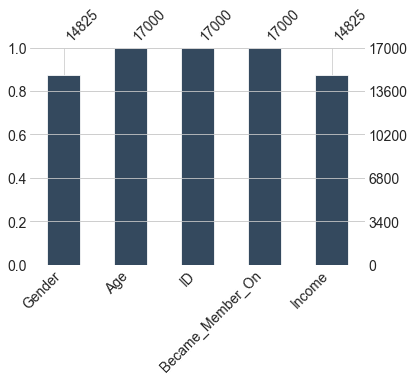

In [5]:
display(Data_info(Profile))
_ = msno.bar(Profile, figsize=(6,4), fontsize=14, log=False, color="#34495e")

### Age

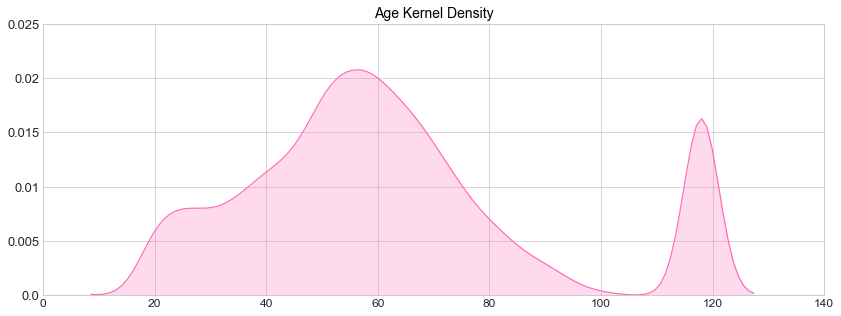

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))
_ = sns.kdeplot(Profile['Age'], shade=True, color='HotPink', ax = ax, legend = False)
_ = ax.set_xlim([0, 140])
_ = ax.set_ylim([0, .025])
_ = ax.set_yticklabels(ax.get_yticks(), size = 13)
_ = ax.set_yticklabels(ax.get_yticks(), size = 13)
_ = ax.set_title('Age Kernel Density', fontsize =14)

One possible reason behind having ages over 100 could be misentering age during user registration. To address this issue, we can search for ages over 100 and impute them with median ages.

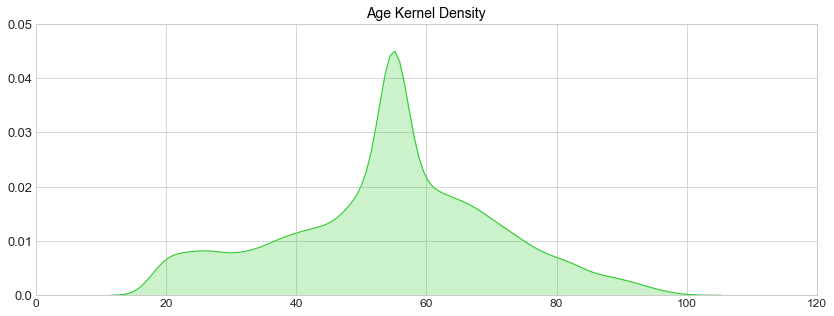

In [7]:
Profile.loc[Profile['Age']>=100, 'Age'] = np.nan

imp = SimpleImputer(missing_values=np.nan, strategy='median')
_ = imp.fit(Profile['Age'].values.reshape(-1,1))
Profile['Age'] = imp.transform(Profile['Age'].values.reshape(-1,1))
del imp

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))
_ = sns.kdeplot(Profile['Age'], shade=True, color='LimeGreen', ax = ax, legend = False)
_ = ax.set_xlim([0, 120])
_ = ax.set_ylim([0, .05])
_ = ax.set_yticklabels(ax.get_yticks(), size = 13)
_ = ax.set_yticklabels(ax.get_yticks(), size = 13)
_ = ax.set_title('Age Kernel Density', fontsize =14)

### Became Member On

In [8]:
# converting 'Became_Member_On' column to a columns with date entries
Profile['Became_Member_On'] = pd.to_datetime(Profile['Became_Member_On'], format='%Y%m%d')
# keeping only the year from 'Became_Member_On' column as 'Member_Since_Year'
Profile['Member_Since_Year'] = Profile['Became_Member_On'].dt.year

Note that

In [9]:
Profile.sort_values(by='Became_Member_On', ascending=True).tail()

,Gender,Age,ID,Became_Member_On,Income,Member_Since_Year
8079,M,82.0,039e0c539c2f4fc582423412a8bceb40,2018-07-26,32000.0,2018
12326,F,59.0,3b9ec536e4224688950913b9cf53362c,2018-07-26,88000.0,2018
10282,M,46.0,e4989ca3d8974e28a3fe87aa0b0ce327,2018-07-26,74000.0,2018
12902,M,85.0,f1f01be4e2344bf08b7f488c115ad374,2018-07-26,45000.0,2018
4357,M,76.0,6597e5ab63754726b83ba2032f008d26,2018-07-26,92000.0,2018


Assuming the data is a snapshot of **the end of 2018**. get member tenure by **the number of months**.

$$Member~Tenure~=(the~end~of~2018)~-~(Became~Member~On)\qquad (In~Months)$$

In [10]:
Temp = pd.to_datetime('20181231', format='%Y%m%d')
Profile['Member_Tenure'] = round((Temp - Profile['Became_Member_On'])/np.timedelta64(1, 'M'))
del Temp

Thus, the Profile data becomes:

In [11]:
Profile.head().style.hide_index()

Gender,Age,ID,Became_Member_On,Income,Member_Since_Year,Member_Tenure
None,55.000000,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12 00:00:00,nan,2017,23.000000
F,55.000000,0610b486422d4921ae7d2bf64640c50b,2017-07-15 00:00:00,112000.000000,2017,18.000000
None,55.000000,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12 00:00:00,nan,2018,6.000000
F,75.000000,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09 00:00:00,100000.000000,2017,20.000000
None,55.000000,a03223e636434f42ac4c3df47e8bac43,2017-08-04 00:00:00,nan,2017,17.000000


### Gender

In [12]:
Profile['Gender'] = Profile['Gender'].replace({'F':'Female', 'M': 'Male', 'O': 'Other'}).fillna('Other')

### Income

Imputing NaN values.

In [13]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
_ = imp.fit(Profile['Income'].values.reshape(-1,1))
Profile['Income'] = imp.transform(Profile['Income'].values.reshape(-1,1))
del imp

,Data Type,Number of NaN Values,Size,Percentage
Age,float64,0,17000,0.0
Became_Member_On,datetime64[ns],0,17000,0.0
Gender,object,0,17000,0.0
ID,object,0,17000,0.0
Income,float64,0,17000,0.0
Member_Since_Year,int64,0,17000,0.0
Member_Tenure,float64,0,17000,0.0


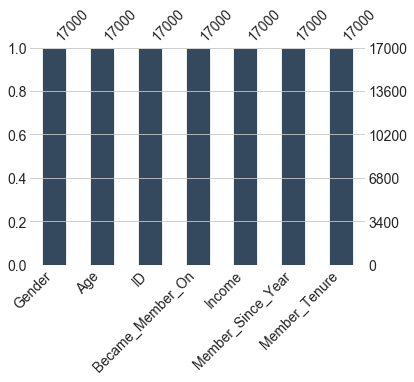

In [14]:
display(Data_info(Profile))
_ = msno.bar(Profile, figsize=(6,4), fontsize=14, log=False, color="#34495e")

## Transcript Data

Looking at the value column from the Transcript Data, we notice that, this data needs to be processed to be used for our analysis. Thus, we are searching for different key-value pairs. That can be done as follows

In [15]:
# We are looking for unique key values
value_keys = []

Counter = 0
Progress_Bar = progressbar.ProgressBar(maxval=Transcript.shape[0],
                                       widgets=[progressbar.Bar('#', '|', '|'), progressbar.Percentage()])
# The Loop
Progress_Bar.start()
for i in range(Transcript.shape[0]):
    Counter+=1
    if Transcript.Value[i].keys() not in value_keys:
        value_keys.append(Transcript.Value[i].keys())

Progress_Bar.finish()
value_keys

|#########################################################################|100%


[dict_keys(['offer id']),
 dict_keys(['amount']),
 dict_keys(['offer_id', 'reward'])]

Now, we divide **offer id** into individual columns

In [16]:
Transcript = pd.concat([Transcript, Transcript['Value'].apply(pd.Series)], axis=1)

Let's look at the resulting DataFrame.

In [17]:
Transcript.head().style.hide_index()

Person,Event,Value,Time,offer id,amount,offer_id,reward
78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,nan,nan,nan
a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,nan,nan
e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,nan,nan,nan
8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,nan,nan,nan
68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,nan,nan,nan


Note that **offer_id** appears in two separate columns since there are two different key types for **offer_id**. We would like to  create a new column to combine the two **offer_id** columns.

In [18]:
Transcript['offer_id_new']=np.where(Transcript['offer id'].isnull() & Transcript['offer_id'].notnull(),
                                    Transcript['offer_id'],Transcript['offer id'])
Transcript.drop(['offer id','offer_id'],axis=1,inplace=True)
Transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [19]:
Transcript.columns = [x.title().replace('Id','ID') for x in Transcript.columns]
Transcript['Event'] = Transcript['Event'].apply(lambda x: x.title())
Transcript.head().style.hide_index()

Person,Event,Value,Time,Amount,Reward,Offer_ID
78afa995795e4d85b5d9ceeca43f5fef,Offer Received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,nan,nan,9b98b8c7a33c4b65b9aebfe6a799e6d9
a03223e636434f42ac4c3df47e8bac43,Offer Received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,nan,nan,0b1e1539f2cc45b7b9fa7c272da2e1d7
e2127556f4f64592b11af22de27a7932,Offer Received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,nan,nan,2906b810c7d4411798c6938adc9daaa5
8ec6ce2a7e7949b1bf142def7d0e0586,Offer Received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,nan,nan,fafdcd668e3743c1bb461111dcafc2a4
68617ca6246f4fbc85e91a2a49552598,Offer Received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,nan,nan,4d5c57ea9a6940dd891ad53e9dbe8da0


Merging Transcript with Portfolio to get offer type.

In [20]:
Data = Transcript.merge(Portfolio,how='left',on='Offer_ID')

However, this creates some undesired columns that we need to modify

In [21]:
# Getting rid of value column
Data.drop('Value', axis=1, inplace=True)
# renaming reward_x and reward_y to reward_received and reward_defined, respectively.
Data.rename(columns={'Reward_x':'Reward_Received', 'Reward_y':'Reward_Defined'},inplace=True)

Therefore,

In [22]:
Data.head().style.hide_index()

Person,Event,Time,Amount,Reward_Received,Offer_ID,Reward_Defined,Difficulty,Duration,Offer_Type,Email,Mobile,Social,Web
78afa995795e4d85b5d9ceeca43f5fef,Offer Received,0,nan,nan,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.000000,5.000000,7.000000,BOGO,1.000000,1.000000,0.000000,1.000000
a03223e636434f42ac4c3df47e8bac43,Offer Received,0,nan,nan,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.000000,20.000000,10.000000,Discount,1.000000,0.000000,0.000000,1.000000
e2127556f4f64592b11af22de27a7932,Offer Received,0,nan,nan,2906b810c7d4411798c6938adc9daaa5,2.000000,10.000000,7.000000,Discount,1.000000,1.000000,0.000000,1.000000
8ec6ce2a7e7949b1bf142def7d0e0586,Offer Received,0,nan,nan,fafdcd668e3743c1bb461111dcafc2a4,2.000000,10.000000,10.000000,Discount,1.000000,1.000000,1.000000,1.000000
68617ca6246f4fbc85e91a2a49552598,Offer Received,0,nan,nan,4d5c57ea9a6940dd891ad53e9dbe8da0,10.000000,10.000000,5.000000,BOGO,1.000000,1.000000,1.000000,1.000000


## Saving

In [23]:
Portfolio.to_csv ('StarBucks\Portfolio_Clean.csv', index = None, header=True)
Profile.to_csv ('StarBucks\Profile_Clean.csv', index = None, header=True)
Transcript.to_csv ('StarBucks\Transcript_Clean.csv', index = None, header=True)
Data.to_csv(r'StarBucks\Data.csv', index = None, header=True)

# Problem Description

## Effective Offers vs. Ineffective Offers

An offer is considered an **<font color='green'>effective</font>** offers if a customer receives an offer, and then view the received offer, and finally, complete a transaction either <font color='blue'>BOGO and Discount Offers</font>, or complete a transaction using <font color='blue'>Informational Offers</font> within the period those offers are valid.

Moroever, an offer that is not classified as **<font color='green'>effective</font>** is considered here as **<font color='red'>ineffective</font>** offers.

Consider the following diagram:

**Effective Offers**:

* Offer received
    * Offer viewed
        * Transaction
            * Offer completed (BOGO and Discount offers)
            * Offer completed (Informational Offers - transactions must happen within the period those offers are valid)
                                   
**Ineffective Offers**:

* Offer Received
    * No action happened
        * No transaction happened
        * Offer not Viewed
    * Offer not Viewed
        * Offer not Viewed
            * Transaction
                * Offer viewed
* Offer not received
    * Transaction 
    
The object of the exercise here is to predict the most suitable offer type that is needed to be sent out to each customer.  In doing so, we need to combine the dataset to build a general database that provides a summary of each user's transactional behaviors.

# Feature Engineering

Let's introduce some new features.

| New Features | Full Features name | Description |
|----------------|------------------------------|----------------------------------------------------------|
| BOGO_Offer_Rec | BOGO Offer Received | The number of BOGO offer received |
| Disc_Offer_Rec | Discount Offer Received | The number of Discount offer received |
| Info_Offer_Rec | Informational Offer Received | The number of Informational offer received |

In [24]:
Temp = Data[Data['Event']=='Offer Received']
Temp = Temp.groupby(['Person','Offer_Type'])['Offer_Type'].agg('count').unstack(level=-1)
# Creating a user data dataframe
# Assigning profile IDs as index of the new dataframe
User_Data = pd.DataFrame(index = Profile['ID'])
# adding Temp to this dataframe
User_Data = User_Data.join(Temp)
del Temp
# renaming
User_Data.rename(columns={'BOGO':'BOGO_Offer_Rec',
                          'Discount':'Disc_Offer_Rec',
                          'Informational':'Info_Offer_Rec'},inplace=True)
User_Data.head()

,BOGO_Offer_Rec,Disc_Offer_Rec,Info_Offer_Rec
ID,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,5.0,NaN
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,NaN,1.0
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0


As can be seen, not all customers received all offers. Let's investigate this a bit further. Since we have three columns (for the three offers), if we have **NaN** greater than 2, then it means that the customers haven't received any offers!

In [25]:
No_Offer = User_Data.isnull().sum(axis=1)
# Creating a list
No_Offer_List=list(No_Offer[No_Offer>2].index)
# Print
print(Fore.BLUE + Style.NORMAL + 'The number of customers that never received any offers' + Style.RESET_ALL
      +' = %i' % No_Offer[No_Offer>2].count())

The number of customers that never received any offers = 6


We can test the results. For example, for the first user from **No_Offer_List**, we have

In [26]:
display(Data[Data['Person'] == No_Offer_List[0]])
del No_Offer, No_Offer_List

,Person,Event,Time,Amount,Reward_Received,Offer_ID,Reward_Defined,Difficulty,Duration,Offer_Type,Email,Mobile,Social,Web
69477,c6e579c6821c41d1a7a6a9cf936e91bb,Transaction,174,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87239,c6e579c6821c41d1a7a6a9cf936e91bb,Transaction,222,1.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163610,c6e579c6821c41d1a7a6a9cf936e91bb,Transaction,408,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243317,c6e579c6821c41d1a7a6a9cf936e91bb,Transaction,570,3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Adding more features to **User_Data** dataframe, we can introduce new parameters.

| New Features | Full Features name | Description |
|----------------|----------------------------|--------------------------------------------------------------------------------------|
| Tot_Tran_Cnt | Total Transaction Count | Whether or not an offer incentivized a transaction |
| Tot_Tran_Amnt | Total Transaction Amount | Total transaction amount |
| Tot_Rewards_Rec | Total Rewards Received | The number of received rewards  from an offer type |
| Ave_Tran_Amnt | Average Transaction Amount | Total transaction amount (TTA) / Total transaction count (TTC) |

<div class="alert alert-block alert-success">
<font size="+1"><b>Total Transaction Count</b></font>
</div>

In [27]:
# Selecting those who had transactions
Temp = Data[Data['Event'] =='Transaction']
# Group by Event for each Person (Total Transactions per person)
Temp = Temp.groupby(['Person'])['Event'].agg({'count'})
Temp.columns = ['Tot_Tran_Cnt']
# Addding it to User_Data
User_Data = User_Data.join(Temp)
del Temp
User_Data.head()

,BOGO_Offer_Rec,Disc_Offer_Rec,Info_Offer_Rec,Tot_Tran_Cnt
ID,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,5.0,NaN,9.0
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0,3.0
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0,6.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,NaN,1.0,7.0
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0,3.0


<div class="alert alert-block alert-success">
<font size="+1"><b>Total Transaction Amount</b></font>
</div>

In [28]:
# Selecting those who had transactions
Temp = Data[Data['Event'] =='Transaction']
# Group by Event for each Person (Total Transactions per person)
Temp = Temp.groupby(['Person'])['Amount'].agg({'sum'})
Temp.columns = ['Tot_Tran_Amnt']
# Addding it to User_Data
User_Data = User_Data.join(Temp)
del Temp
User_Data.head()

,BOGO_Offer_Rec,Disc_Offer_Rec,Info_Offer_Rec,Tot_Tran_Cnt,Tot_Tran_Amnt
ID,,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,5.0,NaN,9.0,20.40
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0,3.0,77.01
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0,6.0,14.30
78afa995795e4d85b5d9ceeca43f5fef,3.0,NaN,1.0,7.0,159.27
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0,3.0,4.65


<div class="alert alert-block alert-success">
<font size="+1"><b>Total Reward Received</b></font>
</div>

In [29]:
# Group by Event for each Person (Total Transactions per person)
Temp = Data.groupby(['Person'])['Reward_Received'].agg({'sum'})
Temp.columns = ['Tot_Rewards_Rec']
# Addding it to User_Data
User_Data = User_Data.join(Temp)
del Temp
User_Data.head()

,BOGO_Offer_Rec,Disc_Offer_Rec,Info_Offer_Rec,Tot_Tran_Cnt,Tot_Tran_Amnt,Tot_Rewards_Rec
ID,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,5.0,NaN,9.0,20.40,5.0
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0,3.0,77.01,5.0
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0,6.0,14.30,0.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,NaN,1.0,7.0,159.27,20.0
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0,3.0,4.65,0.0


<div class="alert alert-block alert-success">
<font size="+1"><b> Average Transaction Amount</b></font>
</div>

$$Average~Transaction~Amount=\frac{Total~Transaction~Amount}{Total~Transaction~Count}$$

In [30]:
User_Data['Ave_Tran_Amnt'] = round(User_Data.Tot_Tran_Amnt/User_Data.Tot_Tran_Cnt,3)

Now we add more parameters to the **User_Data** dataframe.

| New Features        | Full Features name                   | Description                                                                                               |
|-----------------------|----------------------------------------|-----------------------------------------------------------------------------------------------------------|
| Tran_Comp_NO_off      | Transactions Count without any Offers  | The number of transactions for a user completes without an offer                                          |
| Tran_Comp_off         | Transactions Count with Offers         | The number of transactions for a user completes with an offer                                             |
| Tran_Amnt_NO_off      | Transactions Amount without any Offers | The amount of transactions for a user completes without an offer                                          |
| Tran_Amnt_off         | Transactions Amount with Offers        | The amount of transactions for a user completes with an offer                                             |
| Offer_Tran_Cnt_Ratio  | Offer Transactions Count Ratio         | Transaction count incentivized by offer / Total number of transactions - TC_Of/TTC                        |
| Offer_Tran_Amnt_Ratio | Offer Transactions Amount Ratio        | Transaction amount incentivized by offer / Total amount of transactions - TA_Of/TTA                       |
| Offer_Comp_View_Ratio | Offer Completed View Ratio             | The number of offer completed / the number of offer viewed                                                |
| Offer_Comp_Rec_Ratio  | Offer Completed Receive Ratio          | The number of offers completed/ the number of offers received                                             |
| Tran_Amnt_per_Offer   | Transactions Amount per Offer          | The total transaction amount with offer/ Total number of transactions with an offer                       |
| Reward_per_Offer      | Reward per Offer                       | Total rewards received / the number of offer completed                                                    |
| BOGO_Comp             | BOGO Completed                         | The number of offer completed for BOGO offer after viewing the BOGO offer                                 |
| Disc_Comp             | Discount Completed                     | The number of offer completed for Discount offer after viewing the Discount offer                         |
| Info_Comp             | Information Completed                  | The number of offer completed for Information offer after viewing the Information offer                   |
| BOGO_Conv             | BOGO offer conversion rate             | The number of BOGO offers completed / The number of BOGO offer received - BOGO_Comp/BOGO_OR               |
| Info_Conv             | Information offer conversion rate      | The number of Information offers completed / The number of Information offer received - Info_Comp/Info_OR |
| Disc_Conv             | Discount offer conversion rate         | The number of Discount offers completed / The number of Discount offer received - Disc_Comp/Disc_OR       |

Given the fact that **there is no explicit offer conversion** for the parameters that just being introduced. We need to use **nested loops** based on the number of offer completed transaction and transactions amount from the offer conversion.

We can create a function, **User_Record** that takes a user_id and gives all user records as a DataFrame. Then, this function is used to investigate the data based on assumptions that were made at the beginning of this section.

In [31]:
User_Record = lambda user_id: Data[Data['Person'] == user_id].reset_index(drop=True)

For example, we can try

In [32]:
User_Record('68be06ca386d4c31939f3a4f0e3dd783')

,Person,Event,Time,Amount,Reward_Received,Offer_ID,Reward_Defined,Difficulty,Duration,Offer_Type,Email,Mobile,Social,Web
0,68be06ca386d4c31939f3a4f0e3dd783,Offer Received,168,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,Discount,1.0,1.0,0.0,1.0
1,68be06ca386d4c31939f3a4f0e3dd783,Offer Viewed,216,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,Discount,1.0,1.0,0.0,1.0
2,68be06ca386d4c31939f3a4f0e3dd783,Offer Received,336,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,Discount,1.0,0.0,0.0,1.0
3,68be06ca386d4c31939f3a4f0e3dd783,Offer Viewed,348,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,Discount,1.0,0.0,0.0,1.0
4,68be06ca386d4c31939f3a4f0e3dd783,Transaction,360,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,68be06ca386d4c31939f3a4f0e3dd783,Offer Received,408,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,Discount,1.0,1.0,1.0,1.0
6,68be06ca386d4c31939f3a4f0e3dd783,Offer Viewed,408,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,Discount,1.0,1.0,1.0,1.0
7,68be06ca386d4c31939f3a4f0e3dd783,Transaction,414,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,68be06ca386d4c31939f3a4f0e3dd783,Transaction,444,1.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,68be06ca386d4c31939f3a4f0e3dd783,Offer Received,504,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7.0,7.0,Discount,1.0,1.0,1.0,1.0


and get all records of '68be06ca386d4c31939f3a4f0e3dd783'

### Creating a Dictionary for the customer journey

**<font color='orange'>Note</font>**: This might take some time to process!

In [33]:
# Creating an empty dictionary (list)
Person_Effective_Offer = defaultdict(list)

# Creating a list of 'offer_id' for only 'BOGO' and 'Discount' offer types
Bogo_Discount_Offer_IDS = Portfolio[Portfolio['Offer_Type'].isin(['BOGO', 'Discount'])]['Offer_ID'].values

# Person's Transactions from viewed offers (Dictionary)
Person_Off_Trans = defaultdict(lambda: defaultdict(float))

# initial value for Counter
Counter = 0
Progress_Bar = progressbar.ProgressBar(maxval=User_Data.shape[0],
                                       widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage()])
# Starting the Progress Bar
Progress_Bar.start()

# The outer loop for ALL users in the User_Data
for user_id in User_Data.index:
    
    Counter+=1 
    Progress_Bar.update(Counter)
    
    # getting the records for the current user
    Transaction_Received = User_Record(user_id)
    # The index of the received offers
    Offer_Received_Index = Transaction_Received[Transaction_Received['Event'] == 'Offer Received'].index.values
    # All transactions for the current user
    transactions = Transaction_Received[Transaction_Received['Event'] == 'Transaction']
    # Transaction offer index set as empty (for the inside of the inner loop)
    Transaction_Offer_Index = []
    # The iner loop for the received offers indeces
    for R_ind in Offer_Received_Index:
        # offer id corresponding to the index
        offer_id = Transaction_Received.loc[R_ind, 'Offer_ID']
        # offer validity time (convert days to hours using 24 as a multiplier)
        Offer_Valid_For = int(Portfolio[Portfolio['Offer_ID'] == offer_id]['Duration']) * 24
        # offer start time
        Offer_Start = Transaction_Received.loc[R_ind, 'Time']
        # offer end time = offer start time + offer validity time
        Offer_End = Offer_Start + Offer_Valid_For
        # viewed offers (within the offer validity interval)
        viewed = Transaction_Received[(Transaction_Received['Offer_ID'] == offer_id) &
                           (Transaction_Received['Event'] == 'Offer Viewed') &
                           (Transaction_Received['Time'] >= Offer_Start) &
                           (Transaction_Received['Time'] <= Offer_End)]
        # only if "viewed offers" is not empty
        if viewed.shape[0] >0 :
            # add one to the person's viewed offer column 'Offer_View'
            Person_Off_Trans[user_id]['Offer_View'] += 1
            # offer_id from the above list 'Bogo_Discount_Offer_IDS'
            if offer_id in Bogo_Discount_Offer_IDS:
                # checking whether a viewed offer has been completed (within the offer validity interval)
                completed = Transaction_Received[(Transaction_Received['Offer_ID'] == offer_id) &
                           (Transaction_Received['Event'] == 'Offer Completed') &
                           (Transaction_Received['Time'] >= Offer_Start) &
                           (Transaction_Received['Time'] <= Offer_End)]
                # only if "completed offers" is not zero (has some enteries)
                if completed.shape[0] > 0 :
                    View_Ind = viewed.index[0]
                    comp_ind = completed.index[0]
                    Conv_Offer_Type = completed['Offer_Type'].values[0]
                    Offer_Difficulty = completed['Difficulty'].values[0]
                    # if the number of viewed offers is less than the number of completed offers
                    if View_Ind < comp_ind:
                        Person_Off_Trans[user_id]['Offer Completed'] += 1
                        Person_Off_Trans[user_id][Conv_Offer_Type] += 1
                        BOGO_Disc_Trans = transactions.loc[View_Ind:comp_ind]['Amount'].sum()
                        Person_Off_Trans[user_id]['Offer_Trans_Amnt'] += BOGO_Disc_Trans
                        Person_Off_Trans[user_id]['Offer_Difficulty'] += Offer_Difficulty 
                        
                        if offer_id not in Person_Effective_Offer[user_id]:
                            Person_Effective_Offer[user_id].append(offer_id)
                    
            else:
                View_Time = viewed.iloc[0]['Time']
                # add one to the person's viewed offer column 'Offer_View'
                Person_Off_Trans[user_id]['Offer_View'] += 1
                # checking whether a viewed offer has been completed (within the offer validity interval)
                Info_Trans = Transaction_Received[(Transaction_Received['Event'] == 'Transaction') &
                                       (Transaction_Received['Time'] >= View_Time) &
                                       (Transaction_Received['Time'] <= Offer_End)]
                # only if "Info_Trans" is not zero (has some enteries)
                if Info_Trans.shape[0] > 0:
                    Person_Off_Trans[user_id]['Offer Completed'] += 1                    
                    Info_Tran_Amt = Info_Trans['Amount'].sum()
                    Person_Off_Trans[user_id]['Offer_Trans_Amnt'] += Info_Tran_Amt
                    Person_Off_Trans[user_id]['Informational'] +=1
                    if offer_id not in Person_Effective_Offer[user_id]:
                        Person_Effective_Offer[user_id].append(offer_id)
# End of the seraching process
Progress_Bar.finish()

# deleting unnecessary variables
del Progress_Bar, Transaction_Received, Offer_Received_Index, transactions, Transaction_Offer_Index
del offer_id, completed, View_Ind, comp_ind, Conv_Offer_Type, Offer_Difficulty
del BOGO_Disc_Trans, Person_Effective_Offer, View_Time, Info_Trans

[*************************************************************************]100%


Once the searching process has been completed, we can convert the output to a data frame.

In [34]:
# converting the dictionary from the above searching process into data frame
Person_Off_Trans_df = pd.DataFrame.from_dict(Person_Off_Trans, orient = 'index')
# 'comp' stands for completed!
Person_Off_Trans_df = Person_Off_Trans_df.rename(columns={'BOGO':'BOGO_comp',
                                                          'Discount':'Disc_comp',
                                                          'Informational':'Info_comp'})

The output dataframe:

In [35]:
Person_Off_Trans_df.head()

,Offer_View,Offer Completed,Disc_comp,Offer_Trans_Amnt,Offer_Difficulty,BOGO_comp,Info_comp
68be06ca386d4c31939f3a4f0e3dd783,5.0,2.0,2.0,17.71,17.0,NaN,NaN
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,NaN,NaN,NaN,NaN,NaN
78afa995795e4d85b5d9ceeca43f5fef,5.0,3.0,NaN,91.00,15.0,2.0,1.0
a03223e636434f42ac4c3df47e8bac43,5.0,NaN,NaN,NaN,NaN,NaN,NaN
e2127556f4f64592b11af22de27a7932,3.0,2.0,1.0,36.84,15.0,1.0,NaN


Now, 
\begin{align}
\mbox{BOGO Offer} &= \begin{cases} 0 &\mbox{if BOGO_comp is NaN} \\1 & \mbox{else}\end{cases}\\
\mbox{Disc_offer} &= \begin{cases} 0 &\mbox{if Disc_comp is NaN} \\1 & \mbox{else}\end{cases}\\
\mbox{Info_offer} &= \begin{cases} 0 &\mbox{if Info_comp is NaN} \\1 & \mbox{else}\end{cases}
\end{align}

In [36]:
Person_Off_Trans_df['BOGO_offer'] = Person_Off_Trans_df['BOGO_comp'].apply(lambda x: 0 if np.isnan(x) else 1)
Person_Off_Trans_df['Disc_offer'] = Person_Off_Trans_df['Disc_comp'].apply(lambda x: 0 if np.isnan(x) else 1)
Person_Off_Trans_df['Info_offer'] = Person_Off_Trans_df['Info_comp'].apply(lambda x: 0 if np.isnan(x) else 1)
Person_Off_Trans_df.head()

,Offer_View,Offer Completed,Disc_comp,Offer_Trans_Amnt,Offer_Difficulty,BOGO_comp,Info_comp,BOGO_offer,Disc_offer,Info_offer
68be06ca386d4c31939f3a4f0e3dd783,5.0,2.0,2.0,17.71,17.0,NaN,NaN,0,1,0
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
78afa995795e4d85b5d9ceeca43f5fef,5.0,3.0,NaN,91.00,15.0,2.0,1.0,1,0,1
a03223e636434f42ac4c3df47e8bac43,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
e2127556f4f64592b11af22de27a7932,3.0,2.0,1.0,36.84,15.0,1.0,NaN,1,1,0


Merging the current dataframe, `Person_Off_Trans_df`, with the `User_Data` dataframe.

In [37]:
temp = User_Data.join(Person_Off_Trans_df)
User_Data=temp
del temp
User_Data.head()

,BOGO_Offer_Rec,Disc_Offer_Rec,Info_Offer_Rec,Tot_Tran_Cnt,Tot_Tran_Amnt,Tot_Rewards_Rec,Ave_Tran_Amnt,Offer_View,Offer Completed,Disc_comp,Offer_Trans_Amnt,Offer_Difficulty,BOGO_comp,Info_comp,BOGO_offer,Disc_offer,Info_offer
ID,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,5.0,NaN,9.0,20.40,5.0,2.267,5.0,2.0,2.0,17.71,17.0,NaN,NaN,0.0,1.0,0.0
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0,3.0,77.01,5.0,25.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0,6.0,14.30,0.0,2.383,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,NaN,1.0,7.0,159.27,20.0,22.753,5.0,3.0,NaN,91.00,15.0,2.0,1.0,1.0,0.0,1.0
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0,3.0,4.65,0.0,1.550,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


Creating a column **No Offer** such that

$$\text{No Offer}=
\begin{cases}
  1, & \mbox{if there is no offer} \\
  0, & \mbox{if there is at least an offer (BOGO, Discount, Informational)}.
\end{cases} $$

In [38]:
User_Data['No_Offer'] = np.where(User_Data['Offer Completed'].isnull(), 1, 0)

For example, we can see the customer that had no offers:

In [39]:
User_Data.loc[User_Data['No_Offer']==1,:].head()

,BOGO_Offer_Rec,Disc_Offer_Rec,Info_Offer_Rec,Tot_Tran_Cnt,Tot_Tran_Amnt,Tot_Rewards_Rec,Ave_Tran_Amnt,Offer_View,Offer Completed,Disc_comp,Offer_Trans_Amnt,Offer_Difficulty,BOGO_comp,Info_comp,BOGO_offer,Disc_offer,Info_offer,No_Offer
ID,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,1.0,NaN,1.0,3.0,77.01,5.0,25.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
38fe809add3b4fcf9315a9694bb96ff5,1.0,NaN,1.0,6.0,14.30,0.0,2.383,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1
a03223e636434f42ac4c3df47e8bac43,NaN,3.0,2.0,3.0,4.65,0.0,1.550,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1
8ec6ce2a7e7949b1bf142def7d0e0586,1.0,3.0,1.0,NaN,NaN,0.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1
68617ca6246f4fbc85e91a2a49552598,3.0,2.0,NaN,2.0,0.24,0.0,0.120,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1


## Some Additional Features

\begin{align*}
\text{Offer Transaction Count Ratio} &= \frac{\text{Offer Completed}}{\text{Total Transaction Count}},\\
\text{Total Transaction Amount} &= \frac{\text{Offer Transaction Amount}}{\text{Total Transaction Amount}},\\
\text{Offer Transaction Amount Ratio} &= \frac{\text{Offer Transaction Amount}}{\text{Total Transaction Amount}},\\
\text{Viewed Offer Completed Ratio} &= \frac{\text{Offer Completed}}{\text{Offer Viewed}},\\
\text{Transaction Amount per Offer} &= \frac{\text{Offer Transaction Amount}}{\text{Offer Completed}},\\
\text{Reward per offer} &= \frac{\text{Total Reward Received}}{\text{Offer Completed}},\\
\text{Difficulty per Offer} &= \frac{\text{Difficulty per Offer}}{\text{Offer_Difficulty}}.
\end{align*}

In [40]:
# Offer Transaction Count Ratio
User_Data['Offer_Tran_Cnt_Ratio'] = round(User_Data['Offer Completed']/ User_Data['Tot_Tran_Cnt'],2)

# Offer Transaction Amount
User_Data['Offer_Trans_Amnt'] = np.where(User_Data['Offer_Trans_Amnt']>User_Data['Tot_Tran_Amnt'],
                                       User_Data['Tot_Tran_Amnt'], User_Data['Offer_Trans_Amnt'])
# Offer Transaction Amount Ratio
User_Data['Offer_Trans_Amnt_Ratio'] = round(User_Data['Offer_Trans_Amnt']/ User_Data['Tot_Tran_Amnt'],2)

# Viewed Offer Completed Ratio
User_Data['Offer_Comp_View_Ratio'] = User_Data['Offer Completed']/ User_Data['Offer_View']

# Received Offer Completed Ratio
User_Data['Offer_Comp_Rec_Ratio'] = User_Data['Offer Completed']/ User_Data[['BOGO_Offer_Rec','Disc_Offer_Rec',
                                                                                    'Info_Offer_Rec']].sum(axis=1)
# Transaction Amount per Offer
User_Data['Tran_Amnt_per_Offer'] = round(User_Data['Offer_Trans_Amnt']/ User_Data['Offer Completed'],2)

# Reward per offer
User_Data['Reward_per_Offer'] = round(User_Data['Tot_Rewards_Rec']/ User_Data['Offer Completed'],2)

# Difficulty per Offer
User_Data['Difficulty_per_Offer'] = round(User_Data['Offer_Difficulty']/ User_Data['Offer Completed'],2)

In some cases, customers receive rewards without completing any offers. To correct those values, we amount **Total Rewards Received** and **Total Rewards Received** values to zero where **Offer Completed** is zero!

In [41]:
User_Data['Tot_Rewards_Rec'] = np.where(User_Data['Offer Completed']==0, 0 , User_Data['Tot_Rewards_Rec'] )
User_Data['Reward_per_Offer'] = np.where(User_Data['Offer Completed']==0, 0 , User_Data['Reward_per_Offer'] )
User_Data.fillna(0, inplace=True)
User_Data.head()

,BOGO_Offer_Rec,Disc_Offer_Rec,Info_Offer_Rec,Tot_Tran_Cnt,Tot_Tran_Amnt,Tot_Rewards_Rec,Ave_Tran_Amnt,Offer_View,Offer Completed,Disc_comp,...,Disc_offer,Info_offer,No_Offer,Offer_Tran_Cnt_Ratio,Offer_Trans_Amnt_Ratio,Offer_Comp_View_Ratio,Offer_Comp_Rec_Ratio,Tran_Amnt_per_Offer,Reward_per_Offer,Difficulty_per_Offer
ID,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0.0,5.0,0.0,9.0,20.40,5.0,2.267,5.0,2.0,2.0,...,1.0,0.0,0,0.22,0.87,0.4,0.40,8.86,2.50,8.5
0610b486422d4921ae7d2bf64640c50b,1.0,0.0,1.0,3.0,77.01,5.0,25.670,0.0,0.0,0.0,...,0.0,0.0,1,0.00,0.00,0.0,0.00,0.00,0.00,0.0
38fe809add3b4fcf9315a9694bb96ff5,1.0,0.0,1.0,6.0,14.30,0.0,2.383,1.0,0.0,0.0,...,0.0,0.0,1,0.00,0.00,0.0,0.00,0.00,0.00,0.0
78afa995795e4d85b5d9ceeca43f5fef,3.0,0.0,1.0,7.0,159.27,20.0,22.753,5.0,3.0,0.0,...,0.0,1.0,0,0.43,0.57,0.6,0.75,30.33,6.67,5.0
a03223e636434f42ac4c3df47e8bac43,0.0,3.0,2.0,3.0,4.65,0.0,1.550,5.0,0.0,0.0,...,0.0,0.0,1,0.00,0.00,0.0,0.00,0.00,0.00,0.0


Moreover,

In [42]:
profile_dummy = pd.get_dummies(Profile, columns=['Gender'])
profile_dummy.index = profile_dummy['ID']
profile_dummy.drop(['Became_Member_On','Member_Since_Year','ID'],axis=1, inplace=True)
profile_dummy.head()

,Age,Income,Member_Tenure,Gender_Female,Gender_Male,Gender_Other
ID,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,55.0,64000.0,23.0,0,0,1
0610b486422d4921ae7d2bf64640c50b,55.0,112000.0,18.0,1,0,0
38fe809add3b4fcf9315a9694bb96ff5,55.0,64000.0,6.0,0,0,1
78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,20.0,1,0,0
a03223e636434f42ac4c3df47e8bac43,55.0,64000.0,17.0,0,0,1


In [43]:
#finalize the features by joining the two dataframes
Temp = User_Data.join(profile_dummy)
User_Data=Temp
del Temp
User_Data.head()

,BOGO_Offer_Rec,Disc_Offer_Rec,Info_Offer_Rec,Tot_Tran_Cnt,Tot_Tran_Amnt,Tot_Rewards_Rec,Ave_Tran_Amnt,Offer_View,Offer Completed,Disc_comp,...,Offer_Comp_Rec_Ratio,Tran_Amnt_per_Offer,Reward_per_Offer,Difficulty_per_Offer,Age,Income,Member_Tenure,Gender_Female,Gender_Male,Gender_Other
ID,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0.0,5.0,0.0,9.0,20.40,5.0,2.267,5.0,2.0,2.0,...,0.40,8.86,2.50,8.5,55.0,64000.0,23.0,0,0,1
0610b486422d4921ae7d2bf64640c50b,1.0,0.0,1.0,3.0,77.01,5.0,25.670,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,55.0,112000.0,18.0,1,0,0
38fe809add3b4fcf9315a9694bb96ff5,1.0,0.0,1.0,6.0,14.30,0.0,2.383,1.0,0.0,0.0,...,0.00,0.00,0.00,0.0,55.0,64000.0,6.0,0,0,1
78afa995795e4d85b5d9ceeca43f5fef,3.0,0.0,1.0,7.0,159.27,20.0,22.753,5.0,3.0,0.0,...,0.75,30.33,6.67,5.0,75.0,100000.0,20.0,1,0,0
a03223e636434f42ac4c3df47e8bac43,0.0,3.0,2.0,3.0,4.65,0.0,1.550,5.0,0.0,0.0,...,0.00,0.00,0.00,0.0,55.0,64000.0,17.0,0,0,1


In [44]:
# saving as a CSV file
User_Data.to_csv (r'StarBucks\User_Data.csv', index = None, header=True)

***